In [1]:
import os 

import numpy as np

from astropy.cosmology import WMAP5 as cosmo
from astropy.table import Table
from astropy import units as u 
from astropy.coordinates import SkyCoord
from astropy.utils.console import ProgressBar
from astropy.utils.data import download_file

import kcorrect
import kcorrect.utils as ut

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

# Setup

In this notebook, we try to compare the Cosmos catalog to the resutls from the Astrodeep catalog. 

### Load Cosmos Catalog

Cosmos catalog with redshifts (large file):

In [3]:
raw_cosmos_cat = Table.read("https://stsci.box.com/shared/static/t0jjtd0tl2dng2vsagntyfvn99bqurk4.csv")
print(len(raw_cosmos_cat))

185907


Morphology catalog with radii:

In [4]:
TASCA_COSMOS_MORPH = Table.read('https://stsci.box.com/shared/static/s2kyzzqxe0dui6ujr4p059l6smwjmh8x.tbl', format='ascii')

### Define Filters

Define the filter list and their corrections. For now the corrections are set to 0 because the corrected values for these filters are not used in this notebook. We use the corrected values for the UBV filters after the kcorrection.

In [5]:
"""
# AstroDeep filters for comparison 
astrodeep_filter_list = [
    'MAG_B435',
    'MAG_V606',
    'MAG_I814',
    'MAG_Y105',
    'MAG_J125',
    'MAG_JH140',
    'MAG_H160',
    #'MAG_IRAC1',
    #'MAG_IRAC2'
]
"""

filter_list = [
    'subaru_B',
    'subaru_V',
    'subaru_g',
    'subaru_r',
    'subaru_i',
    'subaru_z',
    #'irac_1',
    #'irac_2',
    #'irac_3',
    #'irac_4',
]

correction_const_dict = {
    'subaru_B': 0.,
    'subaru_V': 0.,
    'subaru_g': 0.,
    'subaru_r': 0.,
    'subaru_i': 0.,
    'subaru_z': 0.,
    #'irac_1': 0.,
    #'irac_2': 0.,
    #'irac_3': 0.,
    #'irac_4': 0.,
}

### Filter the Cosmos Catalog

In [6]:
# Filter Params
# -------------
min_z = 0.0
max_z = np.inf

min_mag = 0
max_mag = 35

z_use_exclude_min = np.inf # Z_USE of this value and up will be filtered out

# Do the filtering
# ----------------
cosmos_mask = np.ones((len(raw_cosmos_cat))).astype(bool)
cosmos_mask = cosmos_mask & (raw_cosmos_cat['Z_BEST'] > min_z).astype(bool).data  
cosmos_mask = cosmos_mask & (raw_cosmos_cat['Z_BEST'] < max_z).astype(bool).data 

for f in filter_list:
    cosmos_mask = cosmos_mask & (raw_cosmos_cat[f] > min_mag).astype(bool).data
    cosmos_mask = cosmos_mask & (raw_cosmos_cat[f] < max_mag).astype(bool).data    
    
cosmos_mask = cosmos_mask & np.invert(raw_cosmos_cat['Z_USE'] >= z_use_exclude_min) 

cosmos_cat = raw_cosmos_cat[cosmos_mask]
print(len(cosmos_cat))

179115


### Construct Data Structure

This section constructs the data structure that holds the information we need to compute the kcorrected catalog

In [7]:
cat = {}

mags = {}
mag_err = {}

maggies = {}
maggies_err = {}

z_best = np.array(cosmos_cat['Z_BEST'])

num_sources = None

for f in filter_list:
    cat[f] = cosmos_cat[f]
    
    raw_flux = np.array(cosmos_cat[f])
    raw_err = np.array(cosmos_cat[f+'_err'][:])
    
    mags[f] = -2.5 * np.log10(raw_flux / 3631.1)
    
    mag_err[f] = (2.5 / np.log(10)) * raw_err / raw_flux
    
    maggies[f] = ut.mag2maggies(mags[f])
    maggies_err[f] = ut.invariance(maggies[f], mag_err[f])
    
    if num_sources is None:
        num_sources = len(cat[f])
    else:
        assert num_sources == len(cat[f])

### Distribution of Redshifts

single bin width= 0.0999


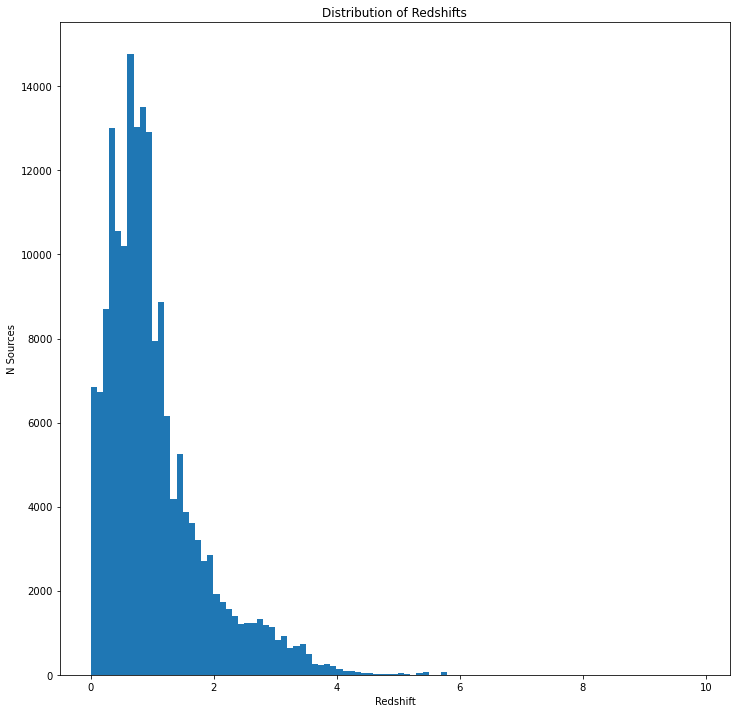

In [8]:
num_bins = 100
max_value = z_best.max()
bin_width = (max_value / num_bins)
print('single bin width=', bin_width)

plt.hist(z_best, bins=[i * bin_width for i in range(num_bins)]);
plt.title("Distribution of Redshifts")
plt.xlabel("Redshift")
plt.ylabel("N Sources")
plt.show()

# Load Radii

Get the radii of sources by matching them to another catalog with radius measurements. Do the matching using the  `match_to_catalog_sky` function and decided the quality of the match by inspecting the distance b/w the coordinates. Use this quality measure to filter out bad matches. At the time of this writing, `separation_2d < 0.1 arcsec`. The sources with no radius will be assigned a value of `np.nan`.

In [9]:
tasca_coords = SkyCoord(
    ra=np.array(TASCA_COSMOS_MORPH['ra'])*u.degree,
    dec=np.array(TASCA_COSMOS_MORPH['dec'])*u.degree
)

cosmos_coords = SkyCoord(
    ra=np.array(cosmos_cat['RA'])*u.degree,
    dec=np.array(cosmos_cat['DEC'])*u.degree
)

In [10]:
idx, sep2d, dist3d = cosmos_coords.match_to_catalog_sky(tasca_coords)

In [11]:
radii = TASCA_COSMOS_MORPH['r_half'][idx] 
radii[np.where(sep2d.arcsec > 0.1)] = np.nan
print("Num sources with radii matchs: ", np.where(sep2d.arcsec < 0.1)[0].shape[0])
print("Fraction sources with radii matchs: ", 1 - np.where(sep2d.arcsec > 0.1)[0].shape[0] / len(cosmos_cat))

Num sources with radii matchs:  102666
Fraction sources with radii matchs:  0.5731848253915082


# Load Input Filters

In [12]:
def print_filter_file(path):
    """Prints the contents of a kcorrect filter file"""
    with open(path) as f:
        for line in f:
            print(line.replace("\n", ""))

In [13]:
input_filter_file = os.path.abspath('lucas_data/lucas_filters2.dat')

In [14]:
print_filter_file(input_filter_file)

KCORRECT_DIR
data/filters/capak_subaru_suprimecam_B.par
data/filters/capak_subaru_suprimecam_V.par
data/filters/capak_subaru_suprimecam_g.par
data/filters/capak_subaru_suprimecam_r.par
data/filters/capak_subaru_suprimecam_i.par
data/filters/capak_subaru_suprimecam_z.par


In [15]:
kcorrect.load_templates()
kcorrect.load_filters(input_filter_file)

# Fit Nonnegative Sums

Fit the data and get kcorrect constants

In [16]:
kcorrect_constants = []

with ProgressBar(len(z_best), ipython_widget=True) as bar:
    
    for i in range(0, num_sources):

        all_maggies = np.array([maggies[f][i] for f in filter_list], dtype=float)
        all_maggies_err = np.array([maggies_err[f][i] for f in filter_list], dtype=float)

        z = z_best[i]

        constants = kcorrect.fit_nonneg(z, all_maggies, all_maggies_err)
        if np.any(np.isnan(np.array(constants))):
            print(constants, i)

        kcorrect_constants.append(constants)

        bar.update()

FloatProgress(value=0.0)

# Reconstruct Maggies

Take the fitted constants and try to reproduce the input maggies to make sure the fit was reasonable

In [17]:
def multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=-1.0):
    re_maggies = {f: [] for f in filter_list}
    
    for constants in kcorrect_constants:
        _, *result = kcorrect.reconstruct_maggies(constants, redshift=redshift)

        for i, f in enumerate(filter_list):
            re_maggies[f].append(result[i])
            
    for i, f in enumerate(filter_list):
        re_maggies[f] = np.array(re_maggies[f])
        
    return re_maggies
    

In [18]:
def stack_filter_dict(dictionary):
    return np.stack(tuple(dictionary.values()), axis=-1)

In [19]:
re_maggies = multi_reconstruct_maggies(kcorrect_constants, filter_list)
re_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=0)

### Compare Reconstructed Maggies Vs Input Maggies

In this section, the present error between the actual data and the reconstructed maggies is computed and the average present error across filters is plotted below.

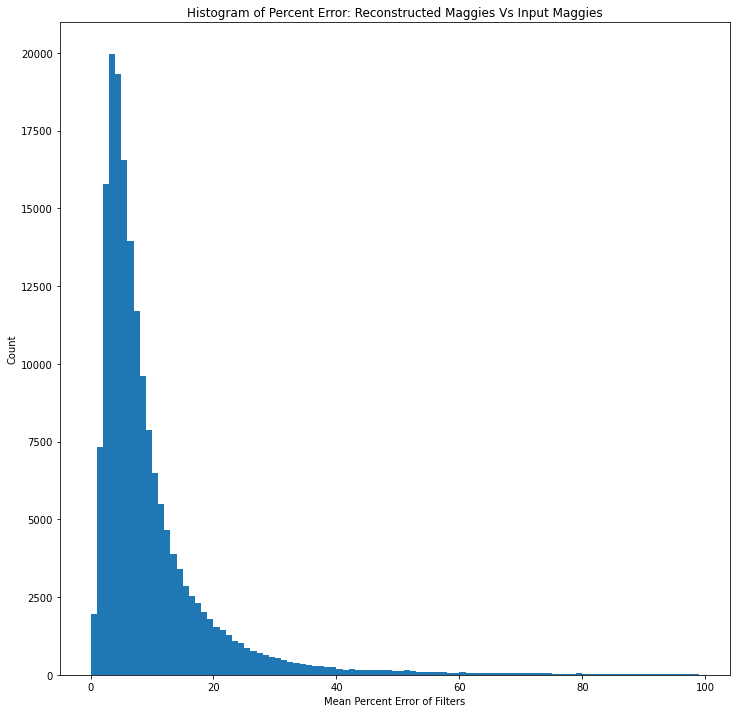

N=179115


In [20]:
all_re_maggies = stack_filter_dict(re_maggies)
all_maggies = stack_filter_dict(maggies)

percent_err = 100 * abs(all_re_maggies - all_maggies) / all_maggies
percent_err = (percent_err).mean(axis=1)

bins = list(range(100))
plt.hist(percent_err, bins=bins)

#plt.xticks(bins, ["{:0.2e}".format(i) for i in bins], rotation='vertical')

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()

"""
bins = 0.1*np.array(range(100))
plt.hist(percent_err, bins=bins)

plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()
"""

print("N={}".format(len(percent_err)))

# Johnson Filters

In [21]:
johnson_filter_list = ['u', 'b', 'v']

johnson_correction_const_dict = {
    'u': -0.79,
    'b': + 0.09,
    'v': -0.02
}

johnson_correction_const = np.array(list(johnson_correction_const_dict.values()))

### Load Johnson Filters

In [22]:
johnson_filter_file = os.path.abspath('johnson_ubv.dat')

In [23]:
print_filter_file(johnson_filter_file)

KCORRECT_DIR
data/filters/bessell_U.par
data/filters/bessell_B.par
data/filters/bessell_V.par


In [24]:
kcorrect.load_templates()
kcorrect.load_filters(johnson_filter_file)

### Compute Johnson Maggies 

In [25]:
johnson_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, johnson_filter_list, redshift=0)

# Compute Vega Mag 

In [26]:
m_vega_mags = {}
M_vega_mags = {}

# Johnson filters
for i, f in enumerate(johnson_filter_list):
    m_vega_mags[f] = -2.5 * np.log10(johnson_maggies_z0[f]) + johnson_correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value

# Original filters
for i, f in enumerate(filter_list):
    m_vega_mags[f] = -2.5 * np.log10(re_maggies_z0[f]) + correction_const_dict[f]
    M_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(z_best).value


# Compute Surface Brightnesses

In [27]:
m_b = m_vega_mags['b']

In [28]:
r_half_light_arcsec = radii * 0.03 * (814 / (445 * (1 + z_best)))**0.108

In [29]:
surface_brightness = m_b + 5 * np.log10(r_half_light_arcsec) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1 + z_best)
surface_brightness[np.where(np.isnan(surface_brightness))] = np.nan

<ipython-input-29-ca8d42a72130>:1: RuntimeWarning: divide by zero encountered in log10
  surface_brightness = m_b + 5 * np.log10(r_half_light_arcsec) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1 + z_best)


# Make Catalog

In [30]:
# Define Column Names
# -------------------

col_names = [
    'ra', 'dec',
    'zbest', 'zuse',
    'surface_brightness',
    'r_half_light_arcsec',
    
] 

col_names += ["m_{}".format(f.replace('MAG_','')) for f in m_vega_mags.keys()] 
col_names += ["M_{}".format(f.replace('MAG_','')) for f in M_vega_mags.keys()]
col_names += ["kcorrect_constant_{}".format(i) for i in range(len(kcorrect_constants[0]))]

# Construct the rows of the catalog
# ----------------------------------

final_catalog_rows = [
    cosmos_cat['RA'],
    cosmos_cat['DEC'],
    np.array(cosmos_cat['Z_BEST']),
    np.array(cosmos_cat['Z_USE']),
] 
final_catalog_rows += [surface_brightness]
final_catalog_rows += [r_half_light_arcsec]
final_catalog_rows += list(m_vega_mags.values()) 
final_catalog_rows += list(M_vega_mags.values()) 
final_catalog_rows += list(map(list, zip(*kcorrect_constants)))    

# Make the catalog
# ----------------

final_catalog = Table(data=final_catalog_rows, names=col_names)

# Filter Catalog
# --------------

# Mask out sources with missing values
# r80 is a good indicator that things failed so we use that column to mask
catalog_mask =  (
    np.invert(np.isnan(surface_brightness)).astype(bool) & 
    np.invert(np.isnan(radii)).astype(bool) &
    (final_catalog['m_subaru_i'] < 22.5).astype(bool) # & 
    #np.invert(final_catalog['zbest'] >= 3) & 
    #(final_catalog['zbest'] > 0.25).astype(bool)&
    #(final_catalog['zbest'] < 0.35).astype(bool)
)

final_catalog = final_catalog[catalog_mask]

final_catalog.sort(keys="r_half_light_arcsec")
print(len(final_catalog))

27979


In [31]:
final_catalog

<Table length=27979>
       ra              dec        ... kcorrect_constant_4 kcorrect_constant_5
                                  ...                                        
    float64          float64      ...       float32             float32      
---------------- ---------------- ... ------------------- -------------------
150.359205922212 1.87645912330616 ...             2.1e-44       5.1437387e-06
149.645318686556 2.35040399602727 ...        6.833095e-23       1.1193517e-07
 150.08845321124 2.24357168957761 ...               9e-44       2.0339773e-27
150.144818212681  2.2449265625278 ...             6.3e-44        7.643906e-35
150.025748879564 1.82794866405978 ...             7.6e-44       4.3383055e-33
150.006449910474   2.265648655219 ...        6.020054e-22             2.8e-44
150.645659730614 2.12274803873176 ...       2.9375247e-21       3.1999356e-10
150.639033607538 2.64247488825442 ...               1e-44               7e-45
149.767879585823 2.25476350689196 ...        3.921242e-06       1.8288132e-10
             ...              ... ...                 ...                 ...
150.022872168418 2.66736978649778 ...        6.517097e-08       1.4764287e-07
150.591166712166 2.24694113018513 ...             1.8e-44             1.7e-44
150.346661927939  2.4041360183092 ...       9.3955305e-06       6.5744574e-09
150.006223427656 2.26649854359005 ...       1.2443962e-08       5.8918467e-08
149.743498532313 1.95778375333841 ...       9.3093564e-07        6.903918e-08
150.331591396532 1.92120776812163 ...        3.145407e-05       3.3235574e-12
150.314596990986  2.4828993024659 ...       3.8951195e-05        3.325332e-12
150.263931968059 2.43471362142961 ...       1.1451428e-05       2.0916828e-09
150.272830786184 2.35736836643022 ...       5.2412265e-06         9.47974e-12
149.784752982648 2.09462918321719 ...       2.7476604e-05         5.18294e-11

# LCBG Catalog

In [32]:
M_B = np.array(final_catalog['M_b'])
M_V = np.array(final_catalog['M_v'])
B_minus_V = M_B-M_V
sb = final_catalog['surface_brightness']

final_cat_zbest = final_catalog['zbest']
final_cat_zuse = final_catalog['zuse']

r_half_light_arcsec_list = final_catalog['r_half_light_arcsec']

# Filter LCBG
# -----------

lcbg_mask = (
    (B_minus_V < 0.5).astype(bool) & 
    (sb < 21).astype(bool) & 
    (M_B < -18.5).astype(bool) & 
    
    #(final_cat_zbest < 0.5).astype(bool)&
    #(final_cat_zbest > 0.1).astype(bool)&
    
    #(r_half_light_arcsec_list < 0.5).astype(bool) & # Guzman et al. (1997) and Phillips et al. (1997)
    (0.2 < r_half_light_arcsec_list).astype(bool)   # Remove star like objects
)

lcbg_catalog = final_catalog[lcbg_mask]
len(lcbg_catalog)

3176

# Save Catalog

In [33]:
output_catalog_filename = "cosmos_kcorrected_catalog.csv"
output_lcbg_catalog_filename = "cosmos_kcorrected_lcbg_catalog.csv"

In [34]:
#final_catalog.write(output_catalog_filename, format="ascii.csv", overwrite=True)
#lcbg_catalog.write(output_lcbg_catalog_filename, format="ascii.csv", overwrite=True)

# Plot Setup

In [35]:
def z_mask(zlist, zmin=0, zmax=np.inf):
    zlist = np.array(zlist)
    return (zlist > zmin).astype(bool) & (zlist < zmax).astype(bool)

z_bins = [
    [0.1, 0.35],
    [0.35, 0.55],
    [0.55, 0.75],
    [0.75, 1.0]
]

# Plot B-V vs M<sub>b</sub> 

#### All data points

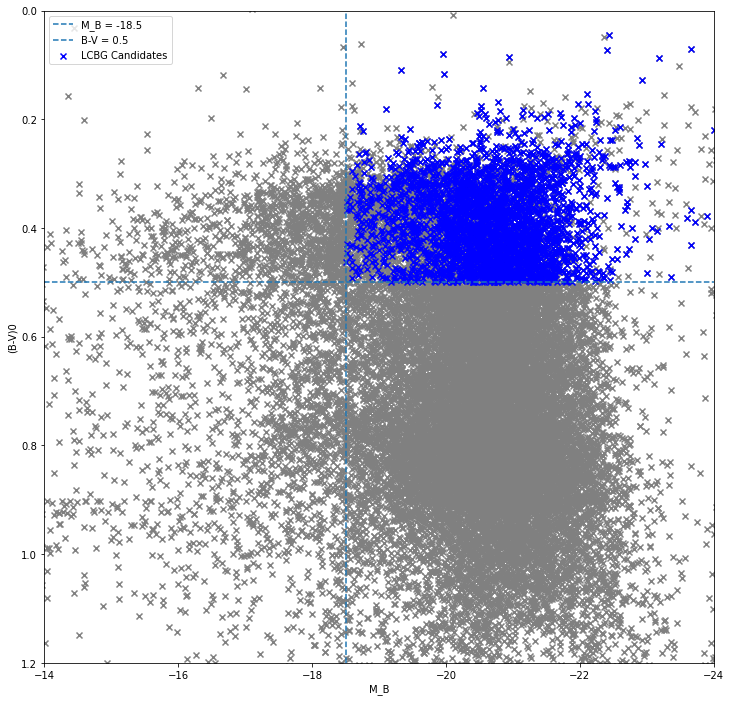

In [36]:
plt.scatter(M_B, B_minus_V, c='gray', marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(0.5, label='B-V = 0.5', linestyle='--')

plt.scatter(M_B[lcbg_mask], B_minus_V[lcbg_mask], label='LCBG Candidates', c='b', marker='x')

plt.xlabel('M_B')
plt.ylabel('(B-V)0')

plt.xlim(-14, -24)
plt.ylim(1.2, -0)

plt.legend()


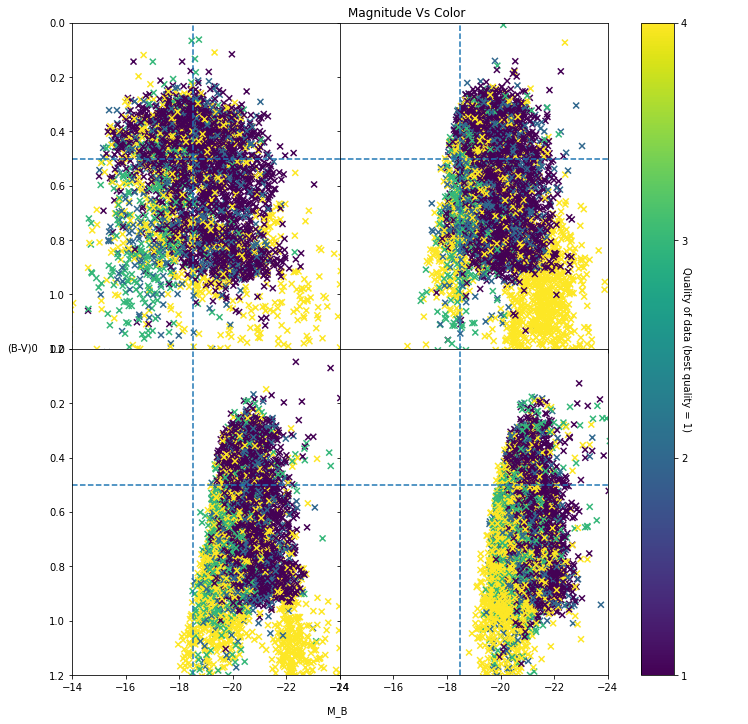

In [37]:
fig, ax_main = plt.subplots(1, 1)
ax_main.axis('off')

axes = fig.subplots(2, 2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for a, zpair in zip(axes.flatten(), z_bins):
    plot_mask = z_mask(final_cat_zbest, *zpair)
    
    scatter = a.scatter(M_B[plot_mask], B_minus_V[plot_mask], c=final_cat_zuse[plot_mask], marker='x')
    
    a.set_xlim(-14, -24)
    a.set_ylim(1.2, -0)
    
    a.axvline(-18.5, label='M_B = -18.5', linestyle='--')
    a.axhline(0.5, label='B-V = 0.5', linestyle='--')


cbar = fig.colorbar(scatter, ax=axes.ravel().tolist())
cbar.set_ticks([1, 2, 3, 4])
cbar.set_label('Quality of data (best quality = 1)', rotation=270)

ax_main.set_title("Magnitude Vs Color")
fig.text(0.42, 0.08, 'M_B')
fig.text(0.05, 0.5, '(B-V)0')
plt.show()

Text(0.05, 0.5, '(B-V)0')

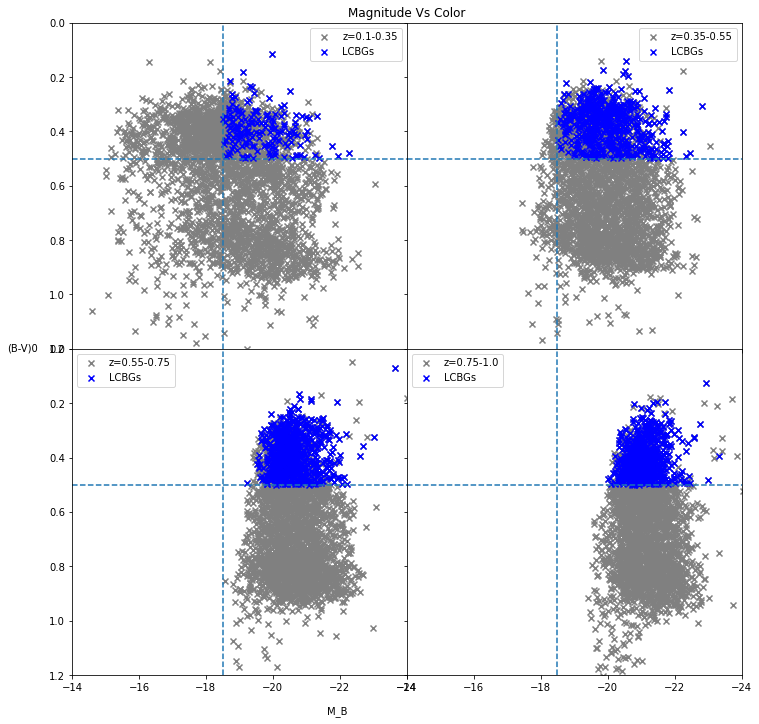

In [38]:
fig, ax_main = plt.subplots(1, 1)
ax_main.axis('off')

axes = fig.subplots(2, 2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for ax, zpair in zip(axes.flatten(), z_bins):
    plot_mask = z_mask(final_cat_zbest, *zpair) & (final_cat_zuse <= 2)
    
    scatter = ax.scatter(M_B[plot_mask], B_minus_V[plot_mask], c='gray', marker='x', label="z={}-{}".format(*zpair))
    
    plot_lcbg_mask = plot_mask & lcbg_mask
    scatter = ax.scatter(M_B[plot_lcbg_mask], B_minus_V[plot_lcbg_mask], c='blue', marker='x', label='LCBGs')
    
    ax.set_xlim(-14, -24)
    ax.set_ylim(1.2, -0)
    
    ax.legend()
    
    ax.axvline(-18.5, label='M_B = -18.5', linestyle='--')
    ax.axhline(0.5, label='B-V = 0.5', linestyle='--')


ax_main.set_title("Magnitude Vs Color")
fig.text(0.42, 0.08, 'M_B')
fig.text(0.05, 0.5, '(B-V)0')

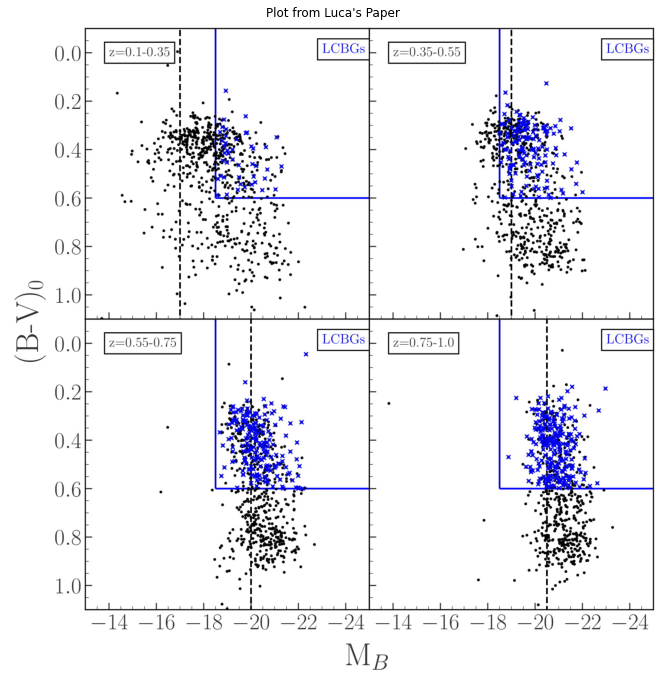

In [39]:
image_file = download_file('https://stsci.box.com/shared/static/9qsh10vc2bj99wbmwpihofdbqxeb3axj.jpg', cache=True)
plot_image = plt.imread(image_file)
plt.imshow(plot_image)
plt.axis('off')
plt.title("Plot from Luca's Paper")
plt.show()

# Plot Surface Brightness Vs M_B

### All data points

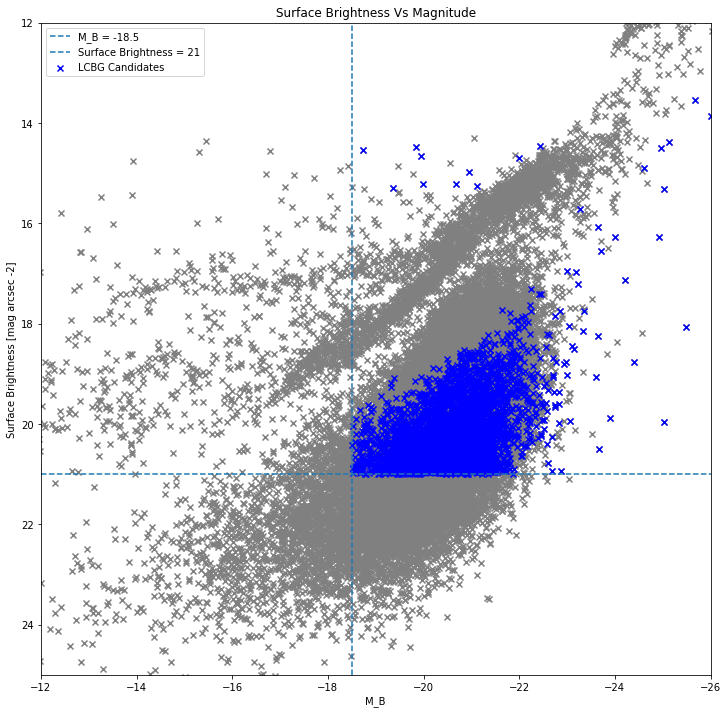

In [40]:
xlim = (-12, -26)
ylim = (25, 12)

# Plot all data and lcbgs
# -----------------------
plt.scatter(M_B, sb, color="gray", marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(M_B[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')

plt.xlabel("M_B")
plt.ylabel("Surface Brightness [mag arcsec -2]")
plt.title("Surface Brightness Vs Magnitude")

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.legend()

plt.show()

### Plot all data with data quality colorbar

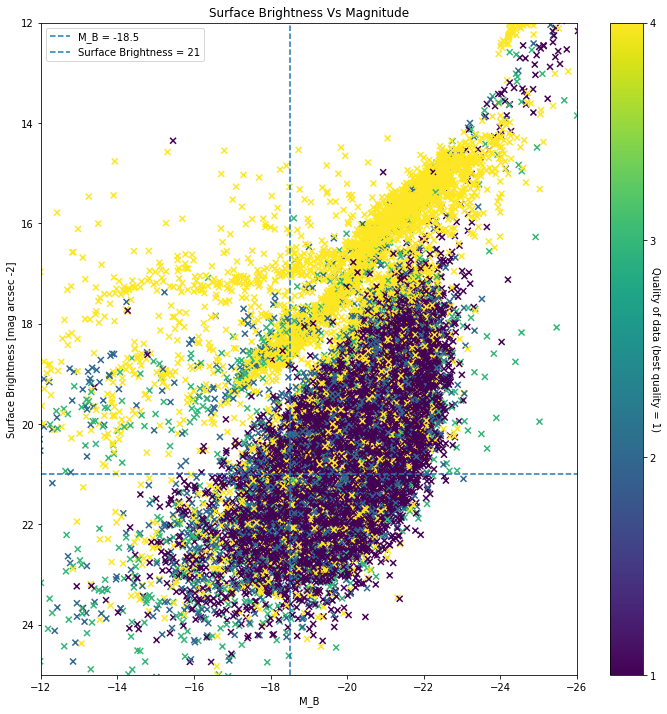

In [41]:
xlim = (-12, -26)
ylim = (25, 12)

# Plot all data with data quality colorbar
# ----------------------------------------
plt.scatter(M_B, sb, c=final_cat_zuse, marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Magnitude")

plt.xlim(*xlim)
plt.ylim(*ylim)

cbar = plt.colorbar()
cbar.set_ticks([1, 2, 3, 4])
cbar.set_label('Quality of data (best quality = 1)', rotation=270)

plt.legend()

plt.show()

### Plot quality data with redshift colorbar

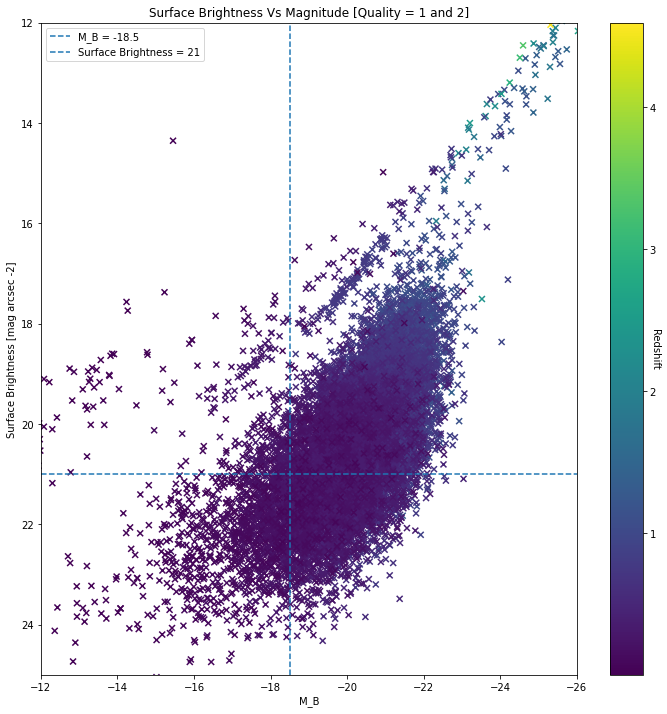

In [42]:
xlim = (-12, -26)
ylim = (25, 12)

# Plot quality data with redshift colorbar
# ----------------------------------------
plot_mask = (final_cat_zuse <= 2)

plt.scatter(M_B[plot_mask], sb[plot_mask], c=final_cat_zbest[plot_mask], marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Magnitude [Quality = 1 and 2]")

plt.xlim(*xlim)
plt.ylim(*ylim)

cbar = plt.colorbar()
cbar.set_label('Redshift', rotation=270)

plt.legend()

plt.show()

### Compare to Paper

Text(0.06, 0.4, 'Surface Brightness [mag arcsec -2]')

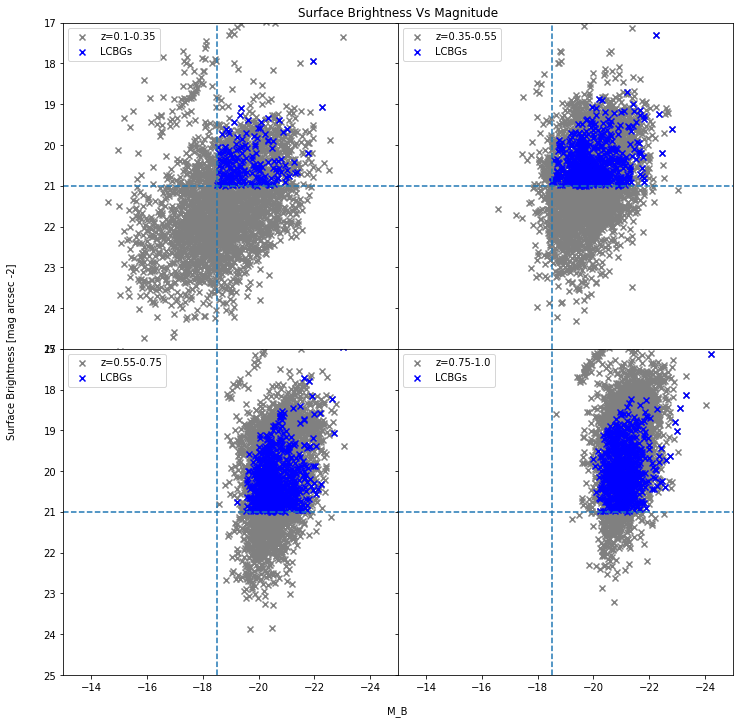

In [43]:
fig, ax_main = plt.subplots(1, 1)
ax_main.axis('off')

axes = fig.subplots(2, 2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for ax, zpair in zip(axes.flatten(), z_bins):
    plot_mask = z_mask(final_cat_zbest, *zpair) & (final_cat_zuse <= 2)
    
    scatter = ax.scatter(M_B[plot_mask], sb[plot_mask], c='gray', marker='x', label="z={}-{}".format(*zpair))
    
    plot_lcbg_mask = plot_mask & lcbg_mask
    scatter = ax.scatter(M_B[plot_lcbg_mask], sb[plot_lcbg_mask], c='blue', marker='x', label='LCBGs')
    
    ax.legend()
    
    ax.axvline(-18.5, label='M_B = -18.5', linestyle='--')
    ax.axhline(21, label='Surface Brightness = 21', linestyle='--')
    
    ax.set_xlim(-13, -25)
    ax.set_ylim(25, 17)
    

ax_main.set_title("Surface Brightness Vs Magnitude")
fig.text(0.5, 0.08, 'M_B')
fig.text(0.06, 0.4, 'Surface Brightness [mag arcsec -2]', rotation=90)

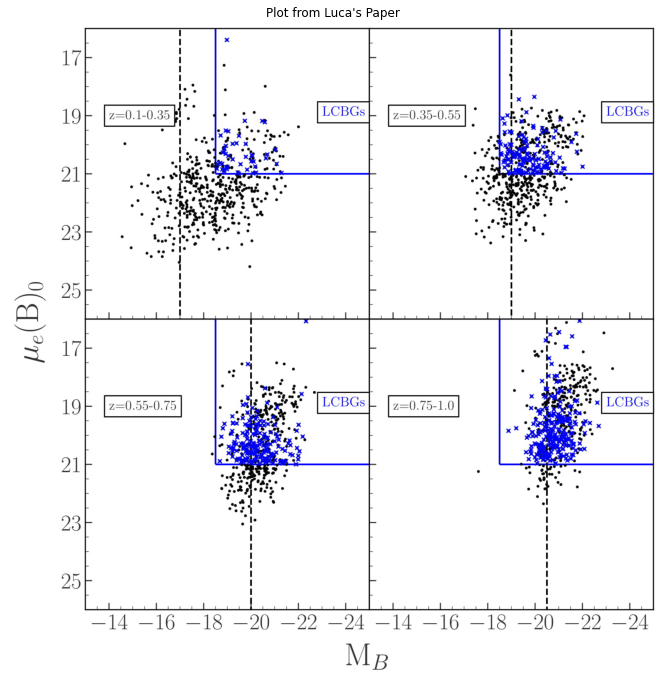

In [44]:
image_file = download_file('https://stsci.box.com/shared/static/hkcls6k03w8xxr0sqyw2y6wcs11n4o5s.jpg', cache=True)
plot_image = plt.imread(image_file)
plt.imshow(plot_image)
plt.axis('off')
plt.title("Plot from Luca's Paper")
plt.show()

# Plot Surface Brightness Vs B-V

### All data points

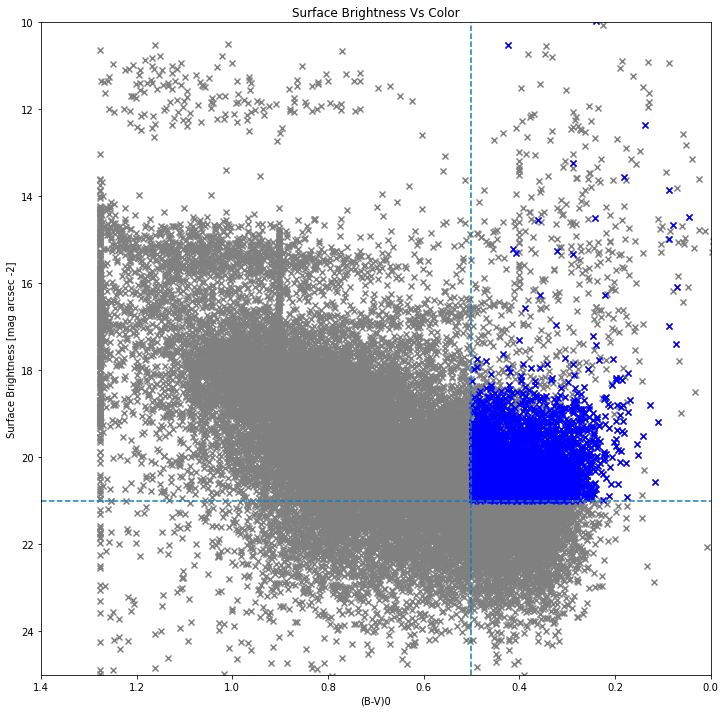

In [45]:
xlim = (1.4, 0.)
ylim = (25, 10)

# Plot all data and lcbgs
# -----------------------

plt.scatter(B_minus_V, sb, color="gray", marker='x')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(B_minus_V[lcbg_mask], sb[lcbg_mask], label='LCBG Candidates', c='b', marker='x')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Color")

plt.xlim(xlim)
plt.ylim(ylim)

#plt.legend()
plt.show()

### Plot all data with data quality colorbar

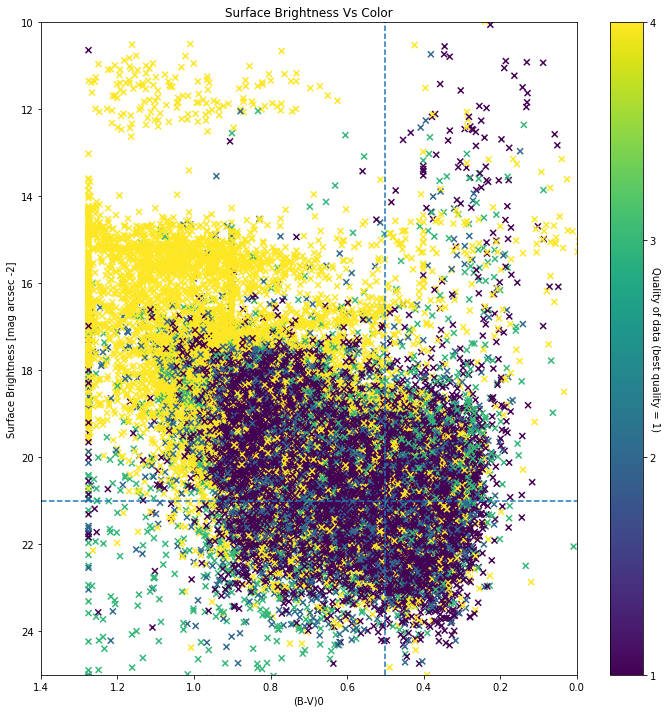

In [46]:
xlim = (1.4, 0.)
ylim = (25, 10)

# Plot all data with data quality colorbar
# ----------------------------------------

plt.scatter(B_minus_V, sb, c=final_cat_zuse, marker='x')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Color")

plt.xlim(xlim)
plt.ylim(ylim)

cbar = plt.colorbar()
cbar.set_ticks([1, 2, 3, 4])
cbar.set_label('Quality of data (best quality = 1)', rotation=270)

### Plot quality data with redshift colorbar

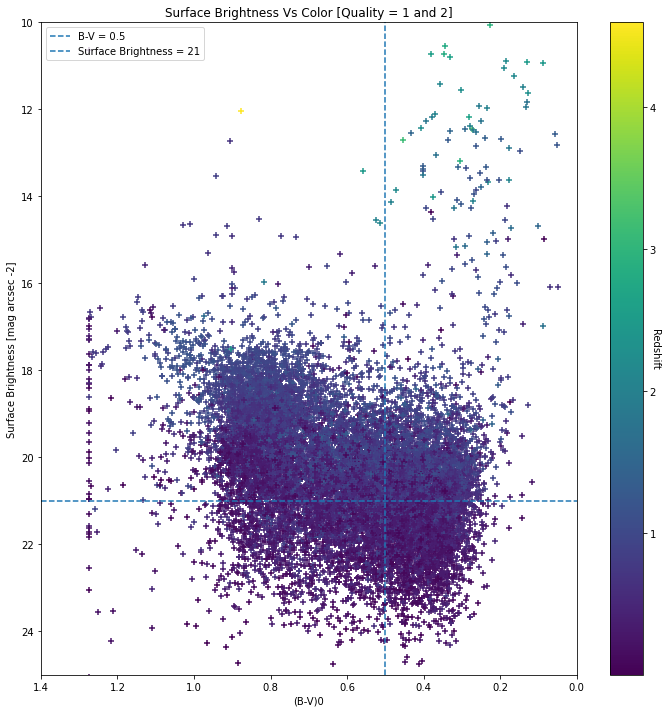

In [47]:
xlim = (1.4, 0.)
ylim = (25, 10)

# Plot quality data with redshift colorbar
# ----------------------------------------
plot_mask = (final_cat_zuse <= 2)

plt.scatter(B_minus_V[plot_mask], sb[plot_mask], c=final_cat_zbest[plot_mask], marker='+')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Color [Quality = 1 and 2]")

plt.xlim(*xlim)
plt.ylim(*ylim)

cbar = plt.colorbar()
cbar.set_label('Redshift', rotation=270)

plt.legend()

plt.show()

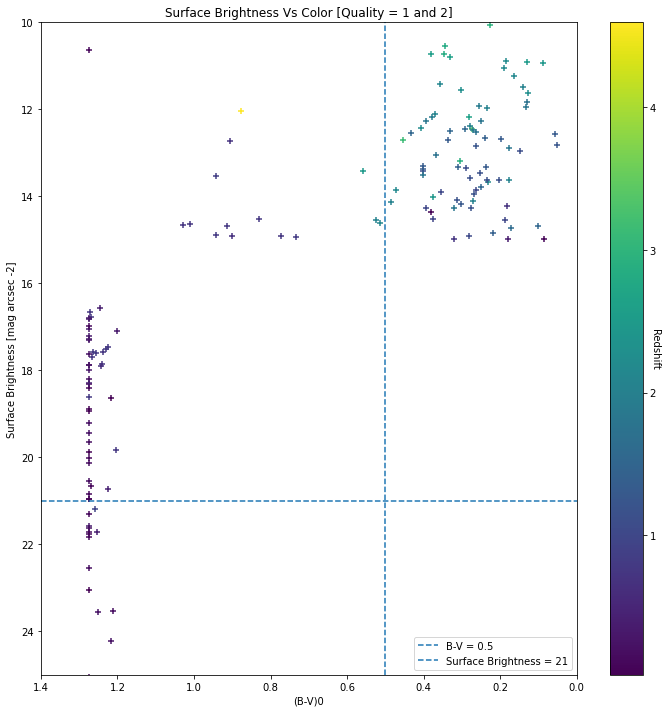

<Table length=156>
       ra              dec        ... kcorrect_constant_4 kcorrect_constant_5
                                  ...                                        
    float64          float64      ...       float32             float32      
---------------- ---------------- ... ------------------- -------------------
150.639033607538 2.64247488825442 ...               1e-44               7e-45
149.767879585823 2.25476350689196 ...        3.921242e-06       1.8288132e-10
150.581148663689  2.2210343881768 ...          6.0347e-41       1.3203398e-08
149.610718114971 2.70837438013935 ...               5e-44       6.6963026e-09
149.649938221162  1.8658670017283 ...             3.5e-44        2.164541e-07
149.738520363621 2.43386262392881 ...             4.6e-44       2.5499462e-08
150.240799068635 2.65903578996754 ...               6e-45       2.5680222e-08
149.771374200355 2.25831426531123 ...        3.145465e-24         6.38002e-08
150.382839070723 2.72363567081717 ...       2.7240911e-12       4.4430157e-09
             ...              ... ...                 ...                 ...
150.427564627175 2.57623827279376 ...       3.3928442e-30             6.4e-44
149.755911884386 2.58441489521872 ...               2e-44               1e-44
150.625617167977 2.70343823195263 ...               3e-45               1e-45
 150.58904519725 2.13695975355781 ...               4e-45               3e-45
150.075889295803 2.20337993316434 ...               4e-45               3e-45
150.266208147851 2.28712354495801 ...             2.5e-44             2.8e-44
150.078683465886 2.12301295895859 ...               6e-45               3e-45
150.198507142833 2.06847596640989 ...               4e-45               3e-45
150.244626576634 2.19432716278077 ...               8e-45               6e-45
150.591166712166 2.24694113018513 ...             1.8e-44             1.7e-44

In [48]:
xlim = (1.4, 0.)
ylim = (25, 10)

# Plot quality data with redshift colorbar
# ----------------------------------------
plot_mask = (final_cat_zuse <= 2) & ((B_minus_V > 1.2) | (sb < 15))

plt.scatter(B_minus_V[plot_mask], sb[plot_mask], c=final_cat_zbest[plot_mask], marker='+')

plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')
plt.title("Surface Brightness Vs Color [Quality = 1 and 2]")

plt.xlim(*xlim)
plt.ylim(*ylim)

cbar = plt.colorbar()
cbar.set_label('Redshift', rotation=270)

plt.legend()

plt.show()


final_catalog[plot_mask]

In [49]:
#for i in list(zip(final_catalog[plot_mask]['r_half_light_arcsec'], final_catalog[plot_mask]['ra'], final_catalog[plot_mask]['dec'])):
#    print(*i)

### Compare to Paper

Text(0.06, 0.4, 'Surface Brightness [mag arcsec -2]')

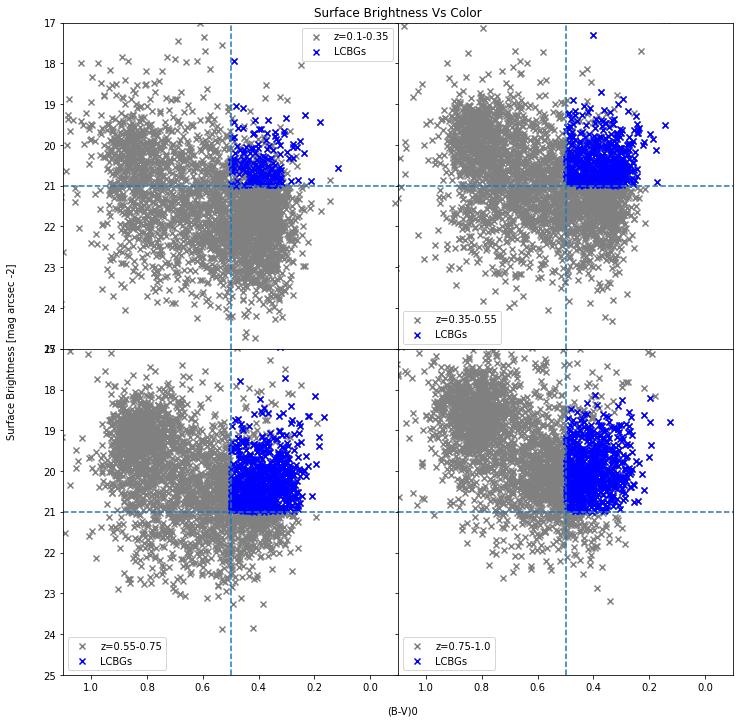

In [50]:
fig, ax_main = plt.subplots(1, 1)
ax_main.axis('off')

axes = fig.subplots(2, 2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0, hspace=0)

for ax, zpair in zip(axes.flatten(), z_bins):
    plot_mask = z_mask(final_cat_zbest, *zpair) & (final_cat_zuse <= 2)
    
    scatter = ax.scatter(B_minus_V[plot_mask], sb[plot_mask], c='gray', marker='x', label="z={}-{}".format(*zpair))
    
    plot_lcbg_mask = plot_mask & lcbg_mask
    scatter = ax.scatter(B_minus_V[plot_lcbg_mask], sb[plot_lcbg_mask], c='blue', marker='x', label='LCBGs')
    
    ax.set_xlim(1.1, -0.1)
    ax.set_ylim(25, 17)
    
    ax.legend()
    
    ax.axvline(0.5, label='B-V = 0.5', linestyle='--')
    ax.axhline(21, label='Surface Brightness = 21', linestyle='--')

ax_main.set_title("Surface Brightness Vs Color")
fig.text(0.5, 0.08, '(B-V)0')
fig.text(0.06, 0.4, 'Surface Brightness [mag arcsec -2]', rotation=90)


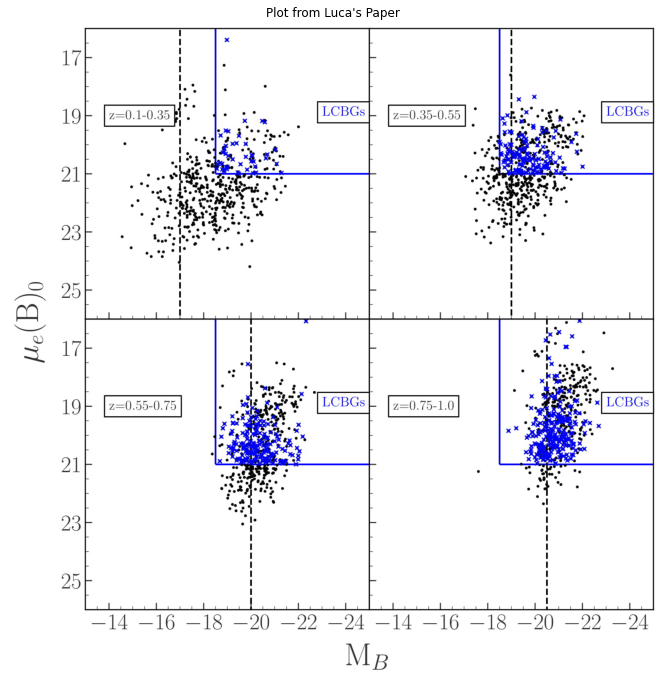

In [51]:
image_file = download_file('https://stsci.box.com/shared/static/hkcls6k03w8xxr0sqyw2y6wcs11n4o5s.jpg', cache=True)
plot_image = plt.imread(image_file)
plt.imshow(plot_image)
plt.axis('off')
plt.title("Plot from Luca's Paper")
plt.show()

# Overplot Astrodeep

In [52]:
robel_plot_path = 'robel_B_minus_V_vs_sb.dat'
if not os.path.exists(robel_plot_path):
    robel_plot_path = "https://stsci.box.com/shared/static/z7wppyr97kzyznra7p6om3kub03tss4h.dat"
robel_plot = Table.read(robel_plot_path, format='ascii',)

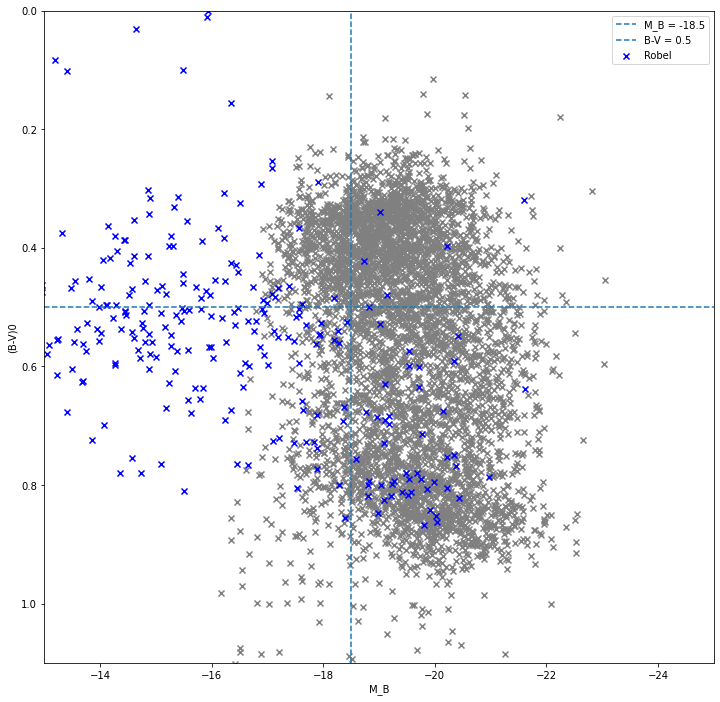

In [53]:
plot_mask = z_mask(final_cat_zbest, 0.2, 0.5) & (final_cat_zuse <= 2)
plt.scatter(M_B[plot_mask], B_minus_V[plot_mask], c='gray', marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(0.5, label='B-V = 0.5', linestyle='--')

plt.scatter(robel_plot['M_B'], robel_plot['B_minus_V'], label='Robel', c='b', marker='x')

plt.xlabel('M_B')
plt.ylabel('(B-V)0')

plt.xlim(-13, -25)
plt.ylim(1.1, -0)

plt.legend()

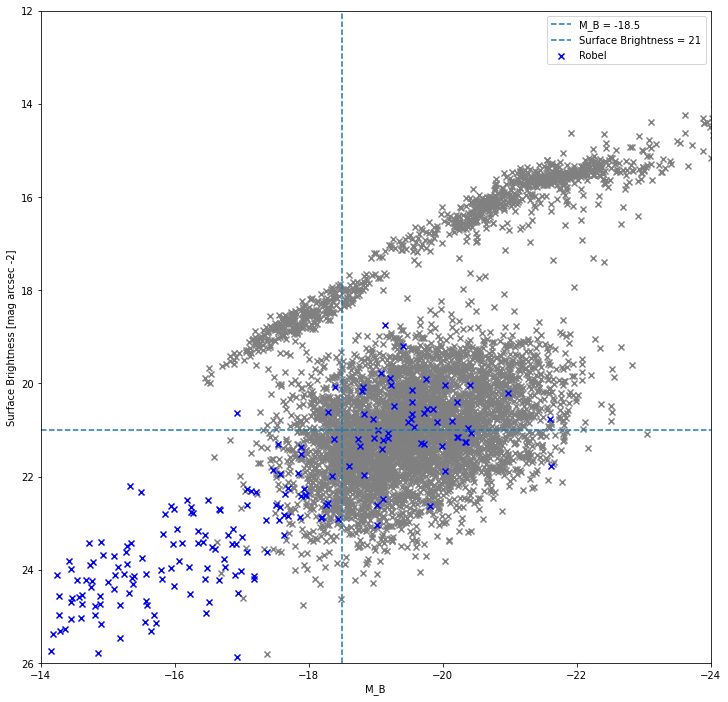

In [54]:
plot_mask = z_mask(final_cat_zbest, 0.3, 0.5) # & (final_cat_zuse <= 2)
plt.scatter(M_B[plot_mask], sb[plot_mask], c='gray', marker='x')

plt.axvline(-18.5, label='M_B = -18.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(robel_plot['M_B'], robel_plot['sb'], label='Robel', c='b', marker='x')

plt.xlabel('M_B')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(-14, -24)
plt.ylim(26, 12)

plt.legend()

(30.0, 12.0)

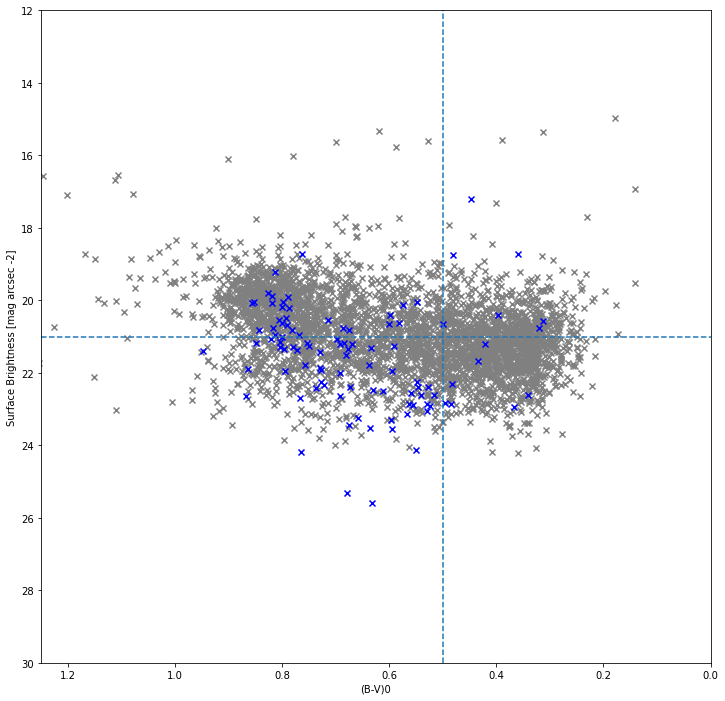

In [55]:
plot_mask = z_mask(final_cat_zbest, 0.3, 0.5) & (final_cat_zuse <= 2)
plt.scatter(B_minus_V[plot_mask], sb[plot_mask], c='gray', marker='x')

robel_plot = Table.read('robel_B_minus_V_vs_sb.dat', format='ascii',)
plt.axvline(0.5, label='B-V = 0.5', linestyle='--')
plt.axhline(21, label='Surface Brightness = 21', linestyle='--')

plt.scatter(robel_plot['B_minus_V'], robel_plot['sb'], label='LCBG Candidates', c='b', marker='x')

plt.xlabel('(B-V)0')
plt.ylabel('Surface Brightness [mag arcsec -2]')

plt.xlim(1.25, 0.)
plt.ylim(30, 12)